In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import imageUtils, postProcessing, DefectDetectionDataset

/Users/mingrenshen/anaconda2/envs/LearningPythonApplicationDevelopment/lib/python3.5/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [3]:
import numpy as np
import os

from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

Specify data root directory if image data exists

In [7]:
root = 'data/'
os.getcwd()

'/Users/mingrenshen/PycharmProjects/defect-detection'

Dowload data if no image data exists. The data is available at [Google Drive](https://drive.google.com/open?id=1mpFjD40cRAkSogUoqMpbUsWJKoTdFXUy) or [Dropbox](https://www.dropbox.com/sh/ttl5u14uzqxrili/AAAa1XMxP9AVJPQ3ie7xZZVxa?dl=0). Download and extract it to the data root directory.

In [8]:
dataset = DefectDetectionDataset(data_dir=root, split='train')
dataset_test = DefectDetectionDataset(data_dir=root, split='test')

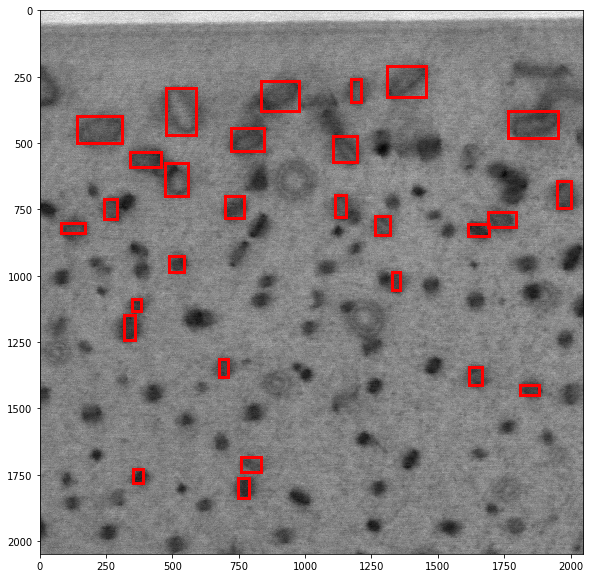

In [9]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[200]
vis_bbox(img, bbox, label, ax=ax1)
plt.show()

# Training Faster-RCNN

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

If train on GPU, set flag ```use_gpu``` to True; otherwise set to False

In [ ]:
use_gpu = False

In [ ]:
import numpy as np

import chainer
from chainer.datasets import ConcatenatedDataset
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger

from chainercv.datasets import voc_bbox_label_names
from chainercv.datasets import VOCBboxDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms


class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale
bbox_label_names = ('loop')

In [ ]:
n_itrs = 70000
n_step = 50000
np.random.seed(0)
train_data = DefectDetectionDataset.DefectDetectionDataset(split='train')
test_data = DefectDetectionDataset.DefectDetectionDataset(split='test')
faster_rcnn = FasterRCNNVGG16(n_fg_class=1, pretrained_model='imagenet')
faster_rcnn.use_preset('evaluate')
model = FasterRCNNTrainChain(faster_rcnn)
device_num = -1
if use_gpu:
    device_num = 0
    chainer.cuda.get_device_from_id(device_num).use()
    model.to_gpu()
optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
train_data = TransformDataset(train_data, Transform(faster_rcnn))
train_iter = chainer.iterators.MultiprocessIterator(
    train_data, batch_size=1, n_processes=None, shared_mem=100000000)
test_iter = chainer.iterators.SerialIterator(
    test_data, batch_size=1, repeat=False, shuffle=False)
updater = chainer.training.updater.StandardUpdater(
    train_iter, optimizer, device=device_num)
trainer = training.Trainer(updater, (n_itrs, 'iteration'), out='result')
trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model_{}.npz'.format(updater.iteration)),
    trigger=(n_itrs/10, 'iteration'))
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(n_step, 'iteration'))
log_interval = 20, 'iteration'
plot_interval = 100, 'iteration'
print_interval = 20, 'iteration'
trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
     ]), trigger=print_interval)
trainer.extend(extensions.ProgressBar(update_interval=5))
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss'],
            file_name='loss.png', trigger=plot_interval
        ),
        trigger=plot_interval
    )
trainer.extend(
    DetectionVOCEvaluator(
        test_iter, model.faster_rcnn, use_07_metric=True,
        label_names=voc_bbox_label_names),
    trigger=ManualScheduleTrigger(
        [100, 500, 1000, 10000, n_step, n_itrs], 'iteration'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.run()

# Testing

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

If need to use CPU for testing, set ```use_gpu``` to False. Otherwise, set it to True

In [14]:
use_gpu = False

model = FasterRCNNVGG16(n_fg_class=1, 
                        pretrained_model='result/snapshot_model_70000.npz')
if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()

In [15]:
bbox_label_names = ('loop')

/Users/mingrenshen/anaconda2/envs/LearningPythonApplicationDevelopment/lib/python3.5/site-packages/chainercv/transforms/image/resize.py:33: RuntimeWarning: cv2 is not installed on your environment. ChainerCV will fall back on Pillow. Installation of cv2 is recommended for faster computation. 
  RuntimeWarning)


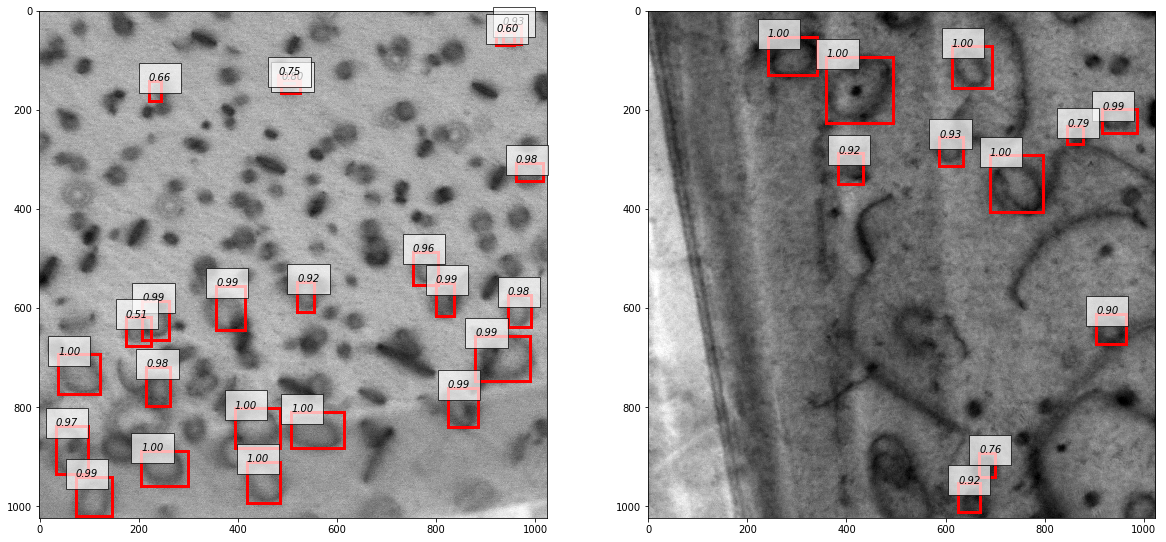

In [16]:
img_0, bbs_1, _ = dataset_test[3]
img_1, bbs_2, _ = dataset_test[14]
model.score_thresh = 0.5
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])
# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bboxes[0], labels[0], scores[0], ax=ax1)
vis_bbox(img_1, bboxes[1], labels[1], scores[1], ax=ax2)
plt.show()

Compare with the ground truth

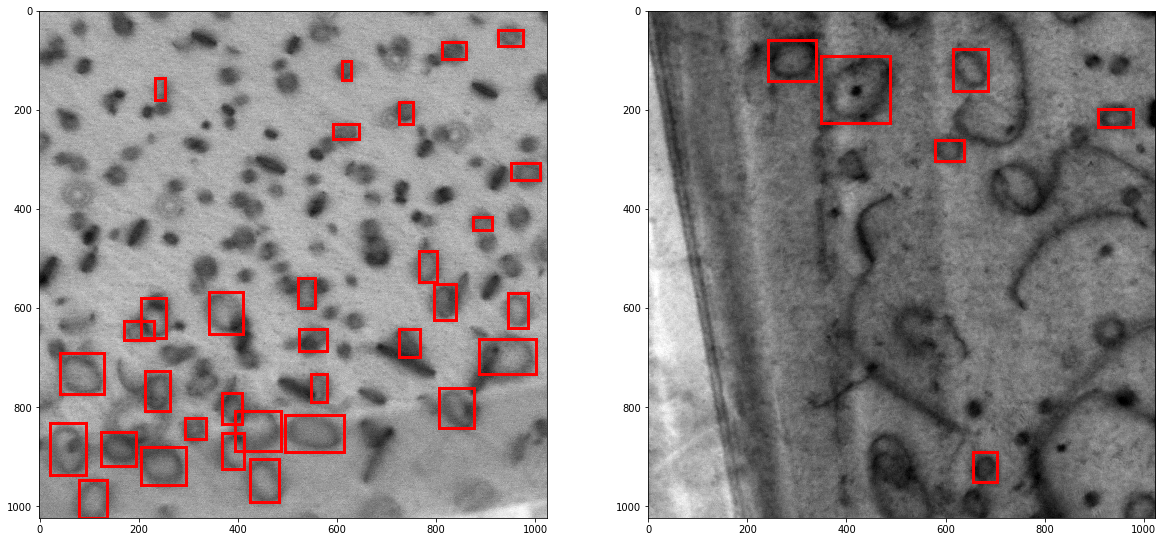

In [17]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bbs_1, ax=ax1)
vis_bbox(img_1, bbs_2, ax=ax2)
plt.show()

In [18]:
from utils import compute_score_by_centroid, evaluate_set_by_centroid

In [19]:
r, p = compute_score_by_centroid(bboxes[0], bbs_1)

In [21]:
recallss, precisions = evaluate_set_by_centroid(model, dataset_test)

/Users/mingrenshen/anaconda2/envs/LearningPythonApplicationDevelopment/lib/python3.5/site-packages/chainercv/transforms/image/resize.py:33: RuntimeWarning: cv2 is not installed on your environment. ChainerCV will fall back on Pillow. Installation of cv2 is recommended for faster computation. 
  RuntimeWarning)


KeyboardInterrupt: 

In [23]:
sum(recallss)/len(recallss)

0.4983468213428385

In [24]:
sum(precisions)/len(precisions)

0.9000683225978927

In [26]:
human_test = DefectDetectionDataset(data_dir=root, split='humantest')

In [43]:
recallss, precisions = evaluate_set_by_centroid(model, human_test, threshold=0.5)

In [44]:
print("Average recall ", sum(recallss)/len(recallss))
print("Average precision ", sum(precisions)/len(precisions))

Average recall  0.5119942479335269
Average precision  0.9271428571428572


In [49]:
min_sz = 10
max_sz = 100
num_bins = 10
threshs = np.linspace(min_sz, max_sz, num=num_bins)

In [57]:
tot_p = tot_g = tp_p = tp_g = [0]*(len(threshs)+1)

In [22]:
def evaluate_set_by_defect_size(model, dataset, threshold=0.5, use_gpu=True):
    min_sz = 10
    max_sz = 100
    num_bins = 10
    splits = np.linspace(min_sz, max_sz, num=num_bins)
    model.score_thresh = threshold
    recall_list = []
    precision_list = []
    for instance in dataset:
        img, gt_bbox, _ = instance
        pred_bbox, _, _ = model.predict([img])
        gt_sz = (gt_bbox[:,2]+gt_bbox[:,3] - gt_bbox[:,0] - gt_bbox[:,1])/2
        pred_
        
        recall_index, precision_index = compute_score_detail_by_centroid(pred_bbox[0], gt_bbox)
        gt_tp_sz = gt_bbox[recall_index, 2] + 
        for i, split in enumerate(splits):
            if 
            
        recall_list.append(recall)
        precision_list.append(precision)
    return recall_list, precision_list

def compute_score_detail_by_centroid(pred_bbox, gt_bbox, tot=[20, 20]):
    pred_c = bbox2centroid(pred_bbox)
    gt_c = bbox2centroid(gt_bbox)
    diffs = abs(pred_c[:,None] - gt_c)
    x1, x2 = np.nonzero((diffs < tot).all(2))
    return x2, x1

SyntaxError: invalid syntax (<ipython-input-22-4e814f2cb812>, line 16)

In [67]:
threshs.shape[0]

10

In [65]:
for i, split in enumerate(threshs):
    print(i, " : ", split)

0  :  10.0
1  :  20.0
2  :  30.0
3  :  40.0
4  :  50.0
5  :  60.0
6  :  70.0
7  :  80.0
8  :  90.0
9  :  100.0


# Post Processing

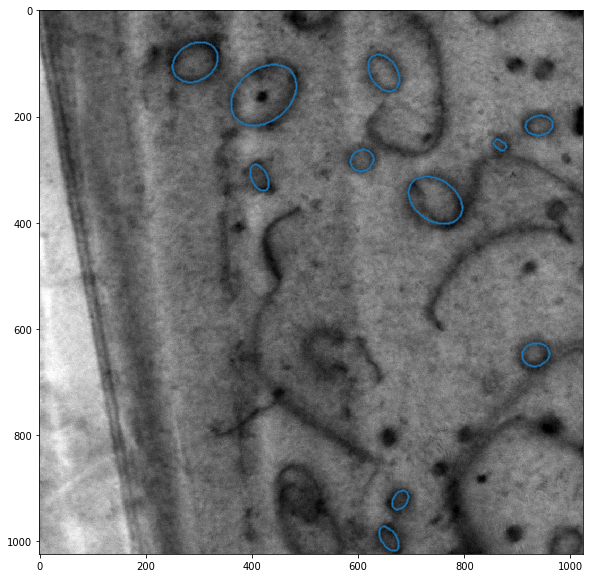

In [23]:
postProcessing.img_ellipse_fitting(img_1,bboxes[1])

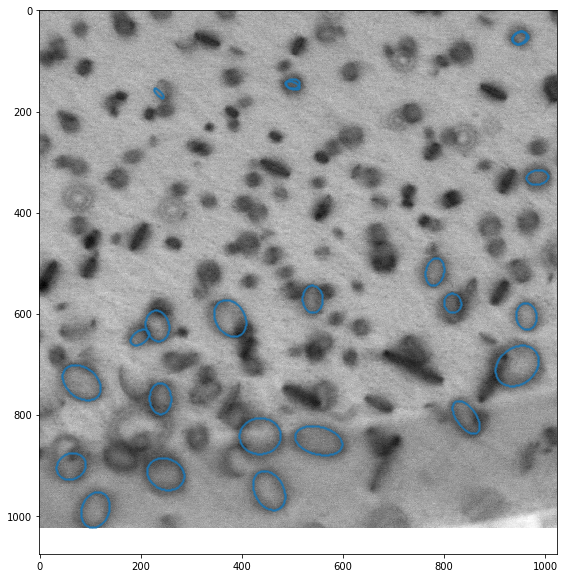

In [25]:
postProcessing.img_ellipse_fitting(img_0,bboxes[0])

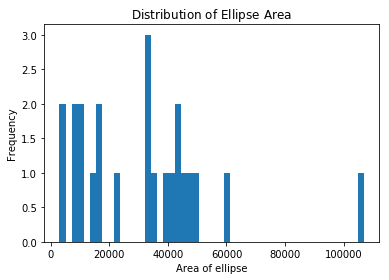

<Figure size 720x720 with 0 Axes>

In [43]:
postProcessing.img_ellipse_fitting_area(img_0,bboxes[0])

# Development Tools

To crop image by the bounding boxes, use ```imageUtils.cropImage``` method

In [14]:
subimages, _ = imageUtils.cropImage(img_0, bbs_1)

To show an image, use ```imageUtils.showImage``` method

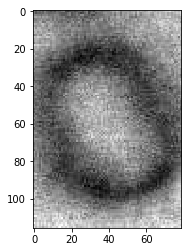

In [15]:
imageUtils.showImage(subimages[6])

To save image, use ```write_image``` method

In [ ]:
write_image(subimages[6], "./subimage6.jpg")